# BA870 - Financial Analytics
# Individual Project - Yipeng Guo / ypguo@bu.edu / U17061528

In [1]:
# Knit
# !jupyter nbconvert -- to pdf /content/Project_Yipeng_Guo.ipynb

## Import libraries and packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

from scipy.stats.mstats import winsorize

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Ⅰ. Upload Datasets

* Fama-French Monthly Risk Factor - 60 months
* Stock Return From 2017.1 - 2021.12
* Ticker - Russel 3000, containing 1,886
* Financial indicators
* Industry indicators


### a. Upload Fama-French monthly risk factor data

In [3]:
ff = pd.read_csv('https://raw.githubusercontent.com/CarolineGuothesweetie/BA870-Project/main/FF-Factors-2017-2021.csv')
ff.head()

,dateff,mktrf,smb,hml,rf
0,20170131,0.0194,-0.0113,-0.0274,0.0004
1,20170228,0.0357,-0.0204,-0.0167,0.0004
2,20170331,0.0017,0.0113,-0.0333,0.0003
3,20170428,0.0109,0.0072,-0.0213,0.0005
4,20170531,0.0106,-0.0252,-0.0375,0.0006


#### (I) Rename the date column as "date" for matching

In [4]:
ff.rename(columns={'dateff':'date'}, inplace=True)
ff.head()

,date,mktrf,smb,hml,rf
0,20170131,0.0194,-0.0113,-0.0274,0.0004
1,20170228,0.0357,-0.0204,-0.0167,0.0004
2,20170331,0.0017,0.0113,-0.0333,0.0003
3,20170428,0.0109,0.0072,-0.0213,0.0005
4,20170531,0.0106,-0.0252,-0.0375,0.0006


#### (II) Check for null values

In [5]:
ff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    60 non-null     int64  
 1   mktrf   60 non-null     float64
 2   smb     60 non-null     float64
 3   hml     60 non-null     float64
 4   rf      60 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 2.5 KB


It turns out that there is no missing values here.

### b. Upload TICKERs dataset

In [6]:
# import tickers 

ticker = pd.read_csv('https://raw.githubusercontent.com/CarolineGuothesweetie/BA870-Project/main/ProjectTickers.csv')

In [7]:
# check tickers row
ticker.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ticker  1886 non-null   object 
 1   Name    1886 non-null   object 
 2   RetYTD  1886 non-null   float64
dtypes: float64(1), object(2)
memory usage: 44.3+ KB


It turns out that there is no missing values here.

### c. Upload WRDS CRSP Stock Return Data
* csv file contains return for 1,886 tickers among 60 months

In [8]:
# Upload the returns and check the info

ret = pd.read_csv('https://raw.githubusercontent.com/CarolineGuothesweetie/BA870-Project/main/Project-2017-21-Returns.csv')
ret.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114715 entries, 0 to 114714
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   PERMNO  114715 non-null  int64 
 1   date    114715 non-null  int64 
 2   TICKER  114653 non-null  object
 3   RET     114700 non-null  object
dtypes: int64(2), object(2)
memory usage: 3.5+ MB


#### (I) Rename the ticker column as 'Ticker' for matching

In [9]:
ret.rename(columns={'TICKER':'Ticker'}, inplace=True)
ret.head()

,PERMNO,date,Ticker,RET
0,10026,20170131,JJSF,-0.043918
1,10026,20170228,JJSF,0.048836
2,10026,20170331,JJSF,0.016293
3,10026,20170428,JJSF,-0.007229
4,10026,20170531,JJSF,-0.033289


#### (II) Check the return dataset & Adjust it
* Whether it only contains 1,886 tickers' related info
* Whether there is missing values or strange values

In [10]:
# Check the length of ticker values uniquely

len(ret['Ticker'].unique())

1925

It seems like this dataset contains some other tickers. Not only 1,886.

In [11]:
# Check the tickers which is "null"
ret['Ticker'].isnull().sum()

62

In [12]:
# Delete the rows which the ticker value is null
ret.dropna(subset=['Ticker'], inplace=True)

There is null values in the ticker column, so we initially drop them.

In [13]:
# Create a ticker list for further use
tic_list = list(ticker['Ticker'].unique())
len(tic_list)

1886

In [14]:
# Check whether there is ticker which is not included in 1886 tickers that still was recorded in the data
tic_strange = []
for i in list(ret['Ticker'].unique()):
  if i not in tic_list:
    tic_strange.append(i)

# Check length
len(tic_strange)

38

It turns out that there are 38 tickers that are not in our Russel 3000 list, so we then drop the entries related with them.

In [15]:
# Delete the data that are in the tickers list
ret = ret[~ret.Ticker.isin(tic_strange)]

In [16]:
# Change RET type to float
ret['RET'] = pd.to_numeric(ret['RET'], errors = 'coerce')

In [17]:
# Check the info
ret.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113160 entries, 0 to 114714
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   PERMNO  113160 non-null  int64  
 1   date    113160 non-null  int64  
 2   Ticker  113160 non-null  object 
 3   RET     113149 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 4.3+ MB


In [18]:
# Fill the null values after changing type as 0
ret['RET'].fillna(0, inplace = True)
ret.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113160 entries, 0 to 114714
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   PERMNO  113160 non-null  int64  
 1   date    113160 non-null  int64  
 2   Ticker  113160 non-null  object 
 3   RET     113160 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 4.3+ MB


Now it's good! It's 1,886 * 60! And we also changed the type of RET from object to float for further use. We can keep going.

### d. Upload Financial Indicators

In [19]:
# Load the financials dataset and check

fin = pd.read_csv('https://raw.githubusercontent.com/CarolineGuothesweetie/BA870-Project/main/Project-2021-Financials.csv')
fin.head()

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,curcd,act,...,csho,dvt,ebit,lct,lt,ni,sale,seq,costat,prcc_c
0,1004,20210531,2020,INDL,C,D,STD,AIR,USD,937.0,...,35.375,0.100,65.50,336.800,565.300,35.80,1651.400,974.4,A,36.22
1,1045,20211231,2021,INDL,C,D,STD,AAL,USD,17336.0,...,647.728,0.000,-5514.00,19006.000,73807.000,-1993.00,29882.000,-7340.0,A,17.96
2,1075,20211231,2021,INDL,C,D,STD,PNW,USD,1551.1,...,112.927,379.108,805.31,1756.869,15981.762,618.72,3803.835,5906.2,A,70.59
3,1078,20211231,2021,INDL,C,D,STD,ABT,USD,24239.0,...,1764.082,3235.000,8966.00,13105.000,39172.000,7071.00,43075.000,35802.0,A,140.74
4,1161,20211231,2021,INDL,C,D,STD,AMD,USD,8583.0,...,1207.000,0.000,3678.00,4240.000,4922.000,3162.00,16434.000,7497.0,A,143.90


In [20]:
fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gvkey     1886 non-null   int64  
 1   datadate  1886 non-null   int64  
 2   fyear     1886 non-null   int64  
 3   indfmt    1886 non-null   object 
 4   consol    1886 non-null   object 
 5   popsrc    1886 non-null   object 
 6   datafmt   1886 non-null   object 
 7   tic       1886 non-null   object 
 8   curcd     1886 non-null   object 
 9   act       1431 non-null   float64
 10  at        1886 non-null   float64
 11  ceq       1886 non-null   float64
 12  csho      1886 non-null   float64
 13  dvt       1877 non-null   float64
 14  ebit      1886 non-null   float64
 15  lct       1431 non-null   float64
 16  lt        1881 non-null   float64
 17  ni        1886 non-null   float64
 18  sale      1886 non-null   float64
 19  seq       1886 non-null   float64
 20  costat    1886 non-null   obje

It turns out there are no missing values in this dataset.

#### (I) Merge financials with ticker dataset
* Change the label for "TIC" in the financials dataframe to "Ticker" to match the "Ticker" label in the "ProjectTickers.csv" dataframe.


In [21]:
# Change the column name
fin.rename(columns={'tic':'Ticker'}, inplace = True)

# Merge
df = pd.merge(ticker, fin, on='Ticker', how='outer')

In [22]:
# Check the merged dataset
df.head()

,Ticker,Name,RetYTD,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,...,csho,dvt,ebit,lct,lt,ni,sale,seq,costat,prcc_c
0,A,Agilent Technologies,-0.2080,126554,20211031,2021,INDL,C,D,STD,...,302.208,236.000,1409.000,1708.000,5316.000,1210.000,6319.000,5389.000,A,159.65
1,AA,Alcoa Corp,0.4731,27638,20211231,2021,INDL,C,D,STD,...,184.100,19.000,2077.000,3223.000,8741.000,429.000,12152.000,4672.000,A,59.58
2,AAL,American Airlines Gp,0.0579,1045,20211231,2021,INDL,C,D,STD,...,647.728,0.000,-5514.000,19006.000,73807.000,-1993.000,29882.000,-7340.000,A,17.96
3,AAN,Aarons Holdings Company,-0.1327,37445,20211231,2021,INDL,C,D,STD,...,30.978,13.269,157.837,NaN,723.099,109.934,1845.504,718.166,A,24.65
4,AAON,Aaon Inc,-0.3456,21542,20211231,2021,INDL,C,D,STD,...,52.528,19.947,73.632,86.768,184.010,58.758,534.517,466.170,A,79.43


In [23]:
# Check the information of the merged dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1886 entries, 0 to 1885
Data columns (total 24 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Ticker    1886 non-null   object 
 1   Name      1886 non-null   object 
 2   RetYTD    1886 non-null   float64
 3   gvkey     1886 non-null   int64  
 4   datadate  1886 non-null   int64  
 5   fyear     1886 non-null   int64  
 6   indfmt    1886 non-null   object 
 7   consol    1886 non-null   object 
 8   popsrc    1886 non-null   object 
 9   datafmt   1886 non-null   object 
 10  curcd     1886 non-null   object 
 11  act       1431 non-null   float64
 12  at        1886 non-null   float64
 13  ceq       1886 non-null   float64
 14  csho      1886 non-null   float64
 15  dvt       1877 non-null   float64
 16  ebit      1886 non-null   float64
 17  lct       1431 non-null   float64
 18  lt        1881 non-null   float64
 19  ni        1886 non-null   float64
 20  sale      1886 non-null   floa

It turns out that we have no null value for now, among all the 1,886 U.S. companies. Good!

### e. Upload Industry Indicators
* Change the column name of TICKER for further use

In [24]:
ind = pd.read_csv('https://raw.githubusercontent.com/CarolineGuothesweetie/BA870-Project/main/Project-2021-Sector.csv')

# Change the column name
ind.rename(columns={'tic':'Ticker'}, inplace = True)
ind.head()

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,Ticker,curcd,costat,ggroup
0,1004,20210531,2020,INDL,C,D,STD,AIR,USD,A,2010
1,1045,20211231,2021,INDL,C,D,STD,AAL,USD,A,2030
2,1075,20211231,2021,INDL,C,D,STD,PNW,USD,A,5510
3,1078,20211231,2021,INDL,C,D,STD,ABT,USD,A,3510
4,1161,20211231,2021,INDL,C,D,STD,AMD,USD,A,4530


## ⅠⅠ. Determine Risk Exposures

### a. Calculate Fama-French Risk Exposure
* (i) Market Risk Exposure
* (ii) Size Risk Exposure and
* (iii) Value/Distress Risk Exposure

#### (I) Create a Loop processing the OLS regression for 100 stocks using FF 3-factor model

* [Ret(x)-Rf] = alpha + B1(RetMkt-Rf) + b2(SMB) + b3(HML) + e

* I would like to create a loop using same logic creating separate dataset of each TICKER, then merge with our FF 3-factors dataset. So I upload the csv.version of TICKER dataset initially.

* Use the same logic processing the regression.


In [25]:
# Create lists for parameters
const = []
mktrf = []
smb = []
hml = []
TICKER = []
Rsquared = []
Adj_Rsquared = []


for tic in ticker['Ticker']:
  # Create new df for x stock - every TICKER go through the loop
  tic_data = ret[ret["Ticker"] == tic]


  # Merge x_data & ff_factors for each x
  tic_ff = pd.merge(tic_data, ff, on='date', how='outer')

  # Run OLS regression for each x (60 months) using FF 3-factor model
  y = tic_ff["RET"] - tic_ff["rf"]
  X = tic_ff[['mktrf' , 'smb' , 'hml']] 

  # Use statsmodels 
  X = sm.add_constant(X) # adding a constant
  model = sm.OLS(y, X)
  result = model.fit()

  # Fill parameters in coordinate list
  const.append(result.params[0])
  mktrf.append(result.params[1])
  smb.append(result.params[2])
  hml.append(result.params[3])
  TICKER.append(tic)
  Rsquared.append(result.rsquared)
  Adj_Rsquared.append(result.rsquared_adj)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


#### (II) Show an example of OSL regression output

In [26]:
result.params

const    0.009920
mktrf    1.249317
smb      2.336902
hml      0.499124
dtype: float64

#### (III) Create final result - combine the OLS regression results with corresponding TICKER

In [27]:
# Create final result:

Results = pd.DataFrame({
                        'Ticker': TICKER,
                        'mktrf': mktrf,
                        'smb': smb,
                        'hml': hml
                        })

### b.Check the results and download to cvs.version file

In [28]:
Results

,Ticker,mktrf,smb,hml
0,A,1.014152,-0.253674,-0.143608
1,AA,1.984149,0.527862,1.924844
2,AAL,1.315550,0.612825,1.248123
3,AAN,1.640807,0.141355,0.841349
4,AAON,0.516779,0.422130,-0.117068
...,...,...,...,...
1881,ZEN,1.026803,1.363839,-0.774104
1882,ZION,1.084739,0.869374,1.151468
1883,ZNGA,0.101034,1.200987,-0.714916
1884,ZTS,0.728418,-0.560814,-0.179065


In [29]:
Results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ticker  1886 non-null   object 
 1   mktrf   1886 non-null   float64
 2   smb     1886 non-null   float64
 3   hml     1886 non-null   float64
dtypes: float64(3), object(1)
memory usage: 59.1+ KB


In [30]:
Results.to_csv("FF-Exposures.csv")

There exsit not missing values, so we directly export the FF-Exposure file as csv format.

## ⅠⅠⅠ. Calculate Financial Ratios

### a. Calculate 12 relevant financial ratios (including market ratios)

In [31]:
# Adding ratios columns

# The very basic but necessary Market Value
df['MKT Value'] = df['csho'] * df['prcc_c']

# Book to Price Ratio-1
df['S/P ratio'] = df['sale'] / df['MKT Value']

# Earning to Price Ratio-2
df['E/P ratio'] = df['ni'] / df['MKT Value']

# Book to Market Ratio-3
df['B/P ratio'] = df['ceq'] / df['MKT Value']

# EBIT to Price Ratio-4
df['EBIT/P'] = df['ebit'] / df['MKT Value']

# Return on Assets-5
df['ROA'] = df['ebit'] / df['at']

# Return on Equity-6
df['ROE'] = df['ebit'] / df['seq']

# Current Ratio-7
df['Current Ratio'] = df['act']/df['lct']

# Gross Profit Margin-8
df['Gross Profit Margin'] = df['ebit'] / df['sale']

# Net Profit Margin-9
df['Net Profit Margin'] = df['ni'] / df['sale']

# Total Liability to Total Equity-10
df['DtoE'] = df['lt'] / df['seq']

# Total Liability to Total Assets-11
df['DtoA'] = df['lt'] / df['at']

# Dividend Payout Ratio-12
df['divpay'] = df['dvt'] / df['ebit']

#### (I) Delete the irrelavant columns and check

In [32]:
df.drop(columns = ['gvkey', 'datadate', 'fyear', 'indfmt', 'consol',
                   'popsrc', 'datafmt', 'curcd', 'Name ', 'RetYTD',
                   'act', 'at', 'ceq', 'csho', 'dvt', 'ebit', 'lct',
                   'lt', 'ni', 'sale', 'seq', 'costat', 'prcc_c'], inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1886 entries, 0 to 1885
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Ticker               1886 non-null   object 
 1   MKT Value            1886 non-null   float64
 2   S/P ratio            1886 non-null   float64
 3   E/P ratio            1886 non-null   float64
 4   B/P ratio            1886 non-null   float64
 5   EBIT/P               1886 non-null   float64
 6   ROA                  1886 non-null   float64
 7   ROE                  1886 non-null   float64
 8   Current Ratio        1431 non-null   float64
 9   Gross Profit Margin  1886 non-null   float64
 10  Net Profit Margin    1886 non-null   float64
 11  DtoE                 1881 non-null   float64
 12  DtoA                 1881 non-null   float64
 13  divpay               1877 non-null   float64
dtypes: float64(13), object(1)
memory usage: 221.0+ KB


We actually have multiple missing values somewhere as follows:
* Current Ratio
* DtoE
* DtoA
* divpay

Let's then deal with them!

### b. Check and deal with abnormal values
* Missing values
* Outliers


#### (I) Dealing with missing values - Fill in with average

In [33]:
# Current Ratio
# Replace the missing values with average
CR_avg = np.average(df['Current Ratio'].dropna())
df['Current Ratio'].fillna(CR_avg,inplace=True)

In [34]:
# DtoE Ratio
# Replace the missing values with average
DE_avg = np.average(df['DtoE'].dropna())
df['DtoE'].fillna(DE_avg,inplace=True)

In [35]:
# DtoA Ratio
# Replace the missing values with average
DA_avg = np.average(df['DtoA'].dropna())
df['DtoA'].fillna(DA_avg,inplace=True)

In [36]:
# Dividend payment ratio
# Replace the missing values with average
dp_avg = np.average(df['divpay'].dropna())
df['divpay'].fillna(DE_avg,inplace=True)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1886 entries, 0 to 1885
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Ticker               1886 non-null   object 
 1   MKT Value            1886 non-null   float64
 2   S/P ratio            1886 non-null   float64
 3   E/P ratio            1886 non-null   float64
 4   B/P ratio            1886 non-null   float64
 5   EBIT/P               1886 non-null   float64
 6   ROA                  1886 non-null   float64
 7   ROE                  1886 non-null   float64
 8   Current Ratio        1886 non-null   float64
 9   Gross Profit Margin  1886 non-null   float64
 10  Net Profit Margin    1886 non-null   float64
 11  DtoE                 1886 non-null   float64
 12  DtoA                 1886 non-null   float64
 13  divpay               1886 non-null   float64
dtypes: float64(13), object(1)
memory usage: 221.0+ KB


In [38]:
df.isna().sum()

Ticker                 0
MKT Value              0
S/P ratio              0
E/P ratio              0
B/P ratio              0
EBIT/P                 0
ROA                    0
ROE                    0
Current Ratio          0
Gross Profit Margin    0
Net Profit Margin      0
DtoE                   0
DtoA                   0
divpay                 0
dtype: int64

Great! Here we finish dealing with missing values, then we'll check outliers and fix them.

#### (II) Dealing with outliers - Winsorize

Considering whether to take logrithm or to winsorize those 12 ratios, I basically think from the following points.

- 1. Those ratios have relatively small standard deviation, some of them are even quite close to each other. Taking logrithm can only make tiny difference to them.
- 2. Also, there exist some negative values of them, scaling from -67 to about -1, logrithm can lead to problems.
- * But if we want to log them, I would suggest take all the negative values as 1, so after logrithm, we will be having zeros, which is a not bad way of dealing with them.

**All in all, I decide to winsorize the ratios.**

In [39]:
df.head()

,Ticker,MKT Value,S/P ratio,E/P ratio,B/P ratio,EBIT/P,ROA,ROE,Current Ratio,Gross Profit Margin,Net Profit Margin,DtoE,DtoA,divpay
0,A,48247.50720,0.130970,0.025079,0.111695,0.029204,0.131621,0.261459,2.224239,0.222978,0.191486,0.986454,0.496590,0.167495
1,AA,10968.67800,1.107882,0.039111,0.425940,0.189357,0.138236,0.444563,1.559417,0.170918,0.035303,1.870933,0.581764,0.009148
2,AAL,11633.19488,2.568684,-0.171320,-0.630953,-0.473988,-0.082958,0.751226,0.912133,-0.184526,-0.066696,-10.055450,1.110431,-0.000000
3,AAN,763.60770,2.416822,0.143967,0.940491,0.206699,0.109513,0.219778,2.738861,0.085525,0.059569,1.006869,0.501711,0.084068
4,AAON,4172.29904,0.128111,0.014083,0.111730,0.017648,0.113249,0.157951,2.513369,0.137754,0.109927,0.394727,0.283014,0.270901


In [40]:
# Wonsorization - (0.02 ~ 0.98)
col = ['S/P ratio', 'E/P ratio', 'B/P ratio', 'EBIT/P', 'ROA', 'ROE',
       'Current Ratio', 'Gross Profit Margin', 'Net Profit Margin',
       'DtoE', 'DtoA', 'divpay']

for i in col:
  df[i] = winsorize(df[i], (0.02, 0.02))

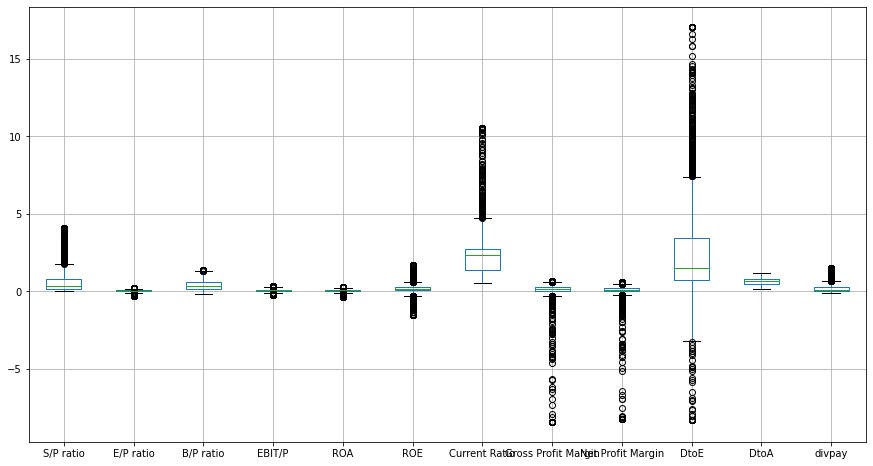

In [41]:
# Generate box plot after winzorization
df.boxplot(column = col, figsize=(15, 8))

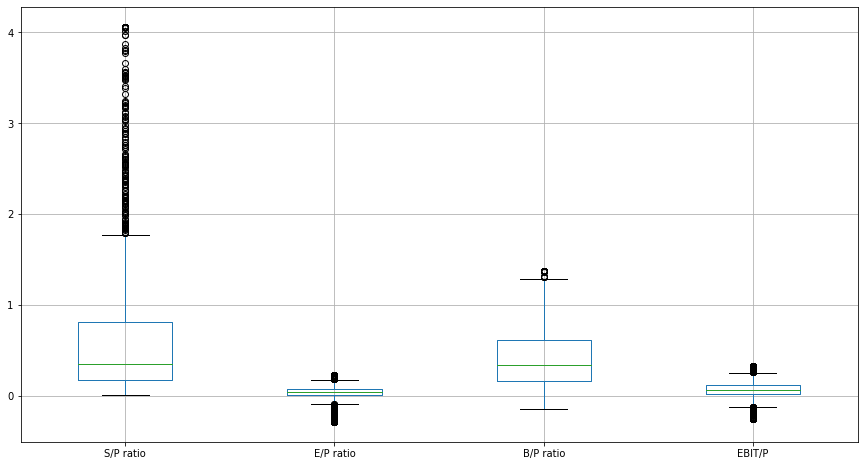

In [42]:
# Box plot for market related ratios
col_mkt = ['S/P ratio', 'E/P ratio', 'B/P ratio', 'EBIT/P']
df.boxplot(column = col_mkt, figsize=(15, 8))

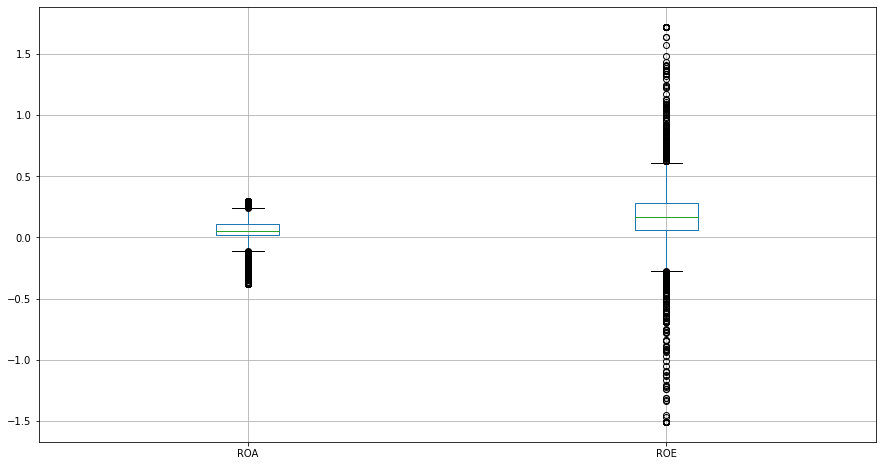

In [43]:
# Box plot of return related ratios
col_ret = ['ROA', 'ROE']
df.boxplot(column = col_ret, figsize=(15, 8))

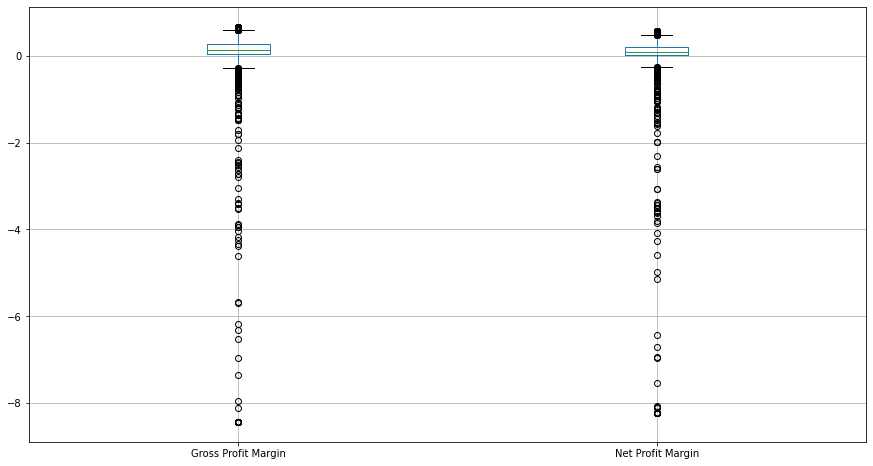

In [44]:
# Box plot of profitability related ratios
col_pro = ['Gross Profit Margin', 'Net Profit Margin']
df.boxplot(column = col_pro, figsize=(15, 8))

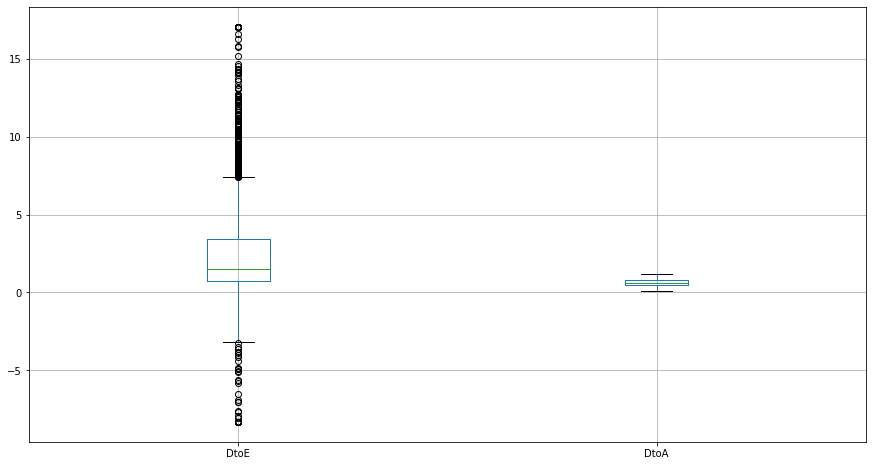

In [45]:
# Box plot of solvency related ratios
col_sol = ['DtoE', 'DtoA']
df.boxplot(column = col_sol, figsize=(15, 8))

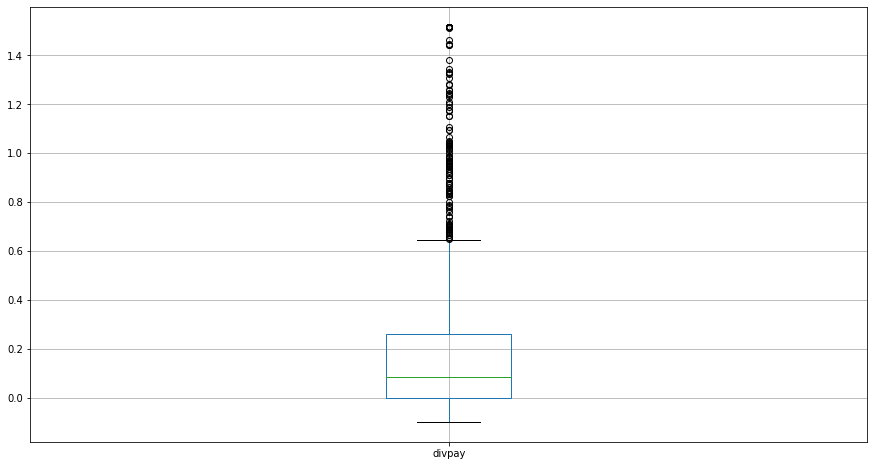

In [46]:
# Box plot of valuation related ratios
col_val = ['divpay']
df.boxplot(column = col_val, figsize=(15, 8))

### c. Save the ticker symbol and financial ratios to csv file

In [47]:
df.drop(columns = ['MKT Value'], inplace = True)
df.to_csv('Fin-Ratios.csv')

## ⅠV. Industry Indicators

### a. Determine industry indicators
#### Create Industry Indicator (category) variables for the 24 Industry categories based on GICS GGROUP.

In [48]:
# Drop irrelavant columns
ind = ind.drop(columns = ['gvkey', 'datadate', 'fyear', 'indfmt', 'consol', 'popsrc',
                         'datafmt', 'curcd', 'costat'])

In [49]:
# Check how many 
ind_count = ind.groupby(by=['ggroup']).count().sort_values(by = ['Ticker']).reset_index()
ind_count

,ggroup,Ticker
0,5010,13
1,3030,17
2,3010,17
3,2510,25
4,2030,39
5,5020,42
6,3020,44
7,4530,55
8,5510,58
9,4030,61


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


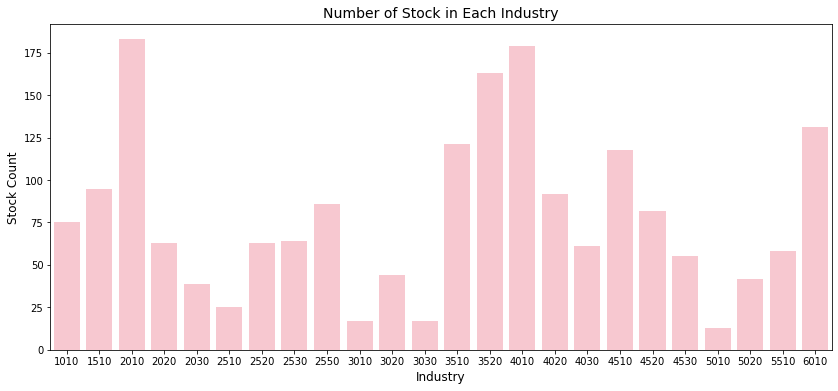

In [50]:
# Plot a distribution of numbers of related ggroup
plt.figure(figsize=(14, 6))
sns.barplot(ind_count.ggroup, ind_count.Ticker,  color="pink")
plt.title('Number of Stock in Each Industry', size = 14)
plt.xlabel('Industry', size = 12)
plt.ylabel('Stock Count', size = 12)
plt.show();

In [51]:
# Get dummies
Industry = pd.get_dummies(ind, columns=['ggroup'])
Industry.head()

,Ticker,ggroup_1010,ggroup_1510,ggroup_2010,ggroup_2020,ggroup_2030,ggroup_2510,ggroup_2520,ggroup_2530,ggroup_2550,...,ggroup_4010,ggroup_4020,ggroup_4030,ggroup_4510,ggroup_4520,ggroup_4530,ggroup_5010,ggroup_5020,ggroup_5510,ggroup_6010
0,AIR,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AAL,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,PNW,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,ABT,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AMD,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [52]:
# Check missing values
Industry.isna().sum()

Ticker         0
ggroup_1010    0
ggroup_1510    0
ggroup_2010    0
ggroup_2020    0
ggroup_2030    0
ggroup_2510    0
ggroup_2520    0
ggroup_2530    0
ggroup_2550    0
ggroup_3010    0
ggroup_3020    0
ggroup_3030    0
ggroup_3510    0
ggroup_3520    0
ggroup_4010    0
ggroup_4020    0
ggroup_4030    0
ggroup_4510    0
ggroup_4520    0
ggroup_4530    0
ggroup_5010    0
ggroup_5020    0
ggroup_5510    0
ggroup_6010    0
dtype: int64

It turns out that there are no missing values. We can proceed and download the dataset as csv format.

### b. Save the industry indicator to csv file

In [53]:
Industry.to_csv('Industry.csv')

## V. Run OLS Explanatory
* Risk Exposures
* Financial Characteristics
* Industry Dummies
* Combined Regression

### a. OLS Regression for Risk Exposures

* (i) Ret(i) = a + b1*MktExposure(i) + b2*SizeExposure(i) +
b3*ValueExposure(i) + e
* (ii) Interpret and explain your findings (focus on R2, Adj R2 and coefficients)

#### (I) Merge the risk exposure with stock returns (on ticker)

In [54]:
# Merge
df_risk = pd.merge(ticker, Results, on='Ticker', how='outer')
df_risk

,Ticker,Name,RetYTD,mktrf,smb,hml
0,A,Agilent Technologies,-0.2080,1.014152,-0.253674,-0.143608
1,AA,Alcoa Corp,0.4731,1.984149,0.527862,1.924844
2,AAL,American Airlines Gp,0.0579,1.315550,0.612825,1.248123
3,AAN,Aarons Holdings Company,-0.1327,1.640807,0.141355,0.841349
4,AAON,Aaon Inc,-0.3456,0.516779,0.422130,-0.117068
...,...,...,...,...,...,...
1881,ZEN,Zendesk Inc,0.2002,1.026803,1.363839,-0.774104
1882,ZION,Zions Bancorp,-0.0038,1.084739,0.869374,1.151468
1883,ZNGA,Zynga Inc Cl A,0.3969,0.101034,1.200987,-0.714916
1884,ZTS,Zoetis Inc Cl A,-0.2325,0.728418,-0.560814,-0.179065


In [55]:
df_risk.isna().sum()

Ticker    0
Name      0
RetYTD    0
mktrf     0
smb       0
hml       0
dtype: int64

It turns out that we have no missing values, so that we can proceed.

#### (II) Run OLS Regression

In [56]:
#MSFT Regression for FF model
y = df_risk['RetYTD']
X = df_risk[['mktrf' , 'smb' , 'hml']] 

# Use statsmodels
X = sm.add_constant(X) # adding a constant
model = sm.OLS(y, X).fit()

#list regression output
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 RetYTD   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     65.51
Date:                Tue, 03 May 2022   Prob (F-statistic):           2.76e-40
Time:                        17:37:11   Log-Likelihood:                 79.945
No. Observations:                1886   AIC:                            -151.9
Df Residuals:                    1882   BIC:                            -129.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0981      0.011     -8.783      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


#### **(III) Explaination of R2, Adj-R2 and coefficients**

- Regression result
> Ret(i) = - 0.0981 + 0.0082 * mktfr - 0.0120 * SMB + 0.1068 * HML

- R-squared & Adj. R-squared
> The value of R-squared is `9.5%` and the Adj. R-squared is `9.3%` , indicating about 9.3% of the stock’s return is explained by the risk exposure measursments. It is relatively low.

- Coef
> - The beta of mktrf is `0.0082`, which means the company's return has positive relation with market risk exposure. Once the risk exposure of the whole market increase, the stock retuns will increase as well. This is quite reasonable - higher risk, higher return. 
> - The beta of SMB is `-0.012`, which means the company's return has negative relation with the size exposure. Once the size exposure turns positive, the return will start to decrease, meaning 2021 is a year of large company. Those ones with negative SMB exposures can gain profit from the market. And the lower the SMB, the better.
> - The beta of HML is 0.1068, which means the company's return has positive relation with the value exposure. Once the size exposure turns positive, the return will start to increase, meaning 2021 is a year of valued company. Those ones with positive HML exposures can gain profit from the market. And the higher the HML, the better.



### b. OLS Regression for financial characteristics

* (i) Ret(i) = a + c1*Ratio1(i) + c2*Ratio2(i) + … + c10*Ratio10(i) + e
* (ii) Interpret and explain your findings (focus on R2, Adj R2 and coefficients)

#### (I) Merge the risk exposure with stock returns (on ticker)

In [57]:
# Merge
df_fin = pd.merge(ticker, df, on='Ticker', how='outer')
df_fin

,Ticker,Name,RetYTD,S/P ratio,E/P ratio,B/P ratio,EBIT/P,ROA,ROE,Current Ratio,Gross Profit Margin,Net Profit Margin,DtoE,DtoA,divpay
0,A,Agilent Technologies,-0.2080,0.130970,0.025079,0.111695,0.029204,0.131621,0.261459,2.224239,0.222978,0.191486,0.986454,0.496590,0.167495
1,AA,Alcoa Corp,0.4731,1.107882,0.039111,0.425940,0.189357,0.138236,0.444563,1.559417,0.170918,0.035303,1.870933,0.581764,0.009148
2,AAL,American Airlines Gp,0.0579,2.568684,-0.171320,-0.148290,-0.257812,-0.082958,0.751226,0.912133,-0.184526,-0.066696,-8.327128,1.110431,-0.000000
3,AAN,Aarons Holdings Company,-0.1327,2.416822,0.143967,0.940491,0.206699,0.109513,0.219778,2.738861,0.085525,0.059569,1.006869,0.501711,0.084068
4,AAON,Aaon Inc,-0.3456,0.128111,0.014083,0.111730,0.017648,0.113249,0.157951,2.513369,0.137754,0.109927,0.394727,0.283014,0.270901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1881,ZEN,Zendesk Inc,0.2002,0.105556,-0.017636,0.038577,-0.011941,-0.061774,-0.309527,1.556646,-0.113122,-0.167073,4.010607,0.800423,-0.000000
1882,ZION,Zions Bancorp,-0.0038,0.310130,0.117891,0.733347,0.188062,0.019324,0.241324,2.738861,0.606397,0.380135,11.488275,0.919925,0.144919
1883,ZNGA,Zynga Inc Cl A,0.3969,0.387066,-0.014402,0.430106,0.032535,0.037019,0.075645,1.054497,0.084056,-0.037208,1.043414,0.510623,0.000000
1884,ZTS,Zoetis Inc Cl A,-0.2325,0.067515,0.017664,0.039394,0.024618,0.204245,0.624917,3.856427,0.364629,0.261623,2.059432,0.673094,0.179288


In [58]:
df_fin.isna().sum()

Ticker                 0
Name                   0
RetYTD                 0
S/P ratio              0
E/P ratio              0
B/P ratio              0
EBIT/P                 0
ROA                    0
ROE                    0
Current Ratio          0
Gross Profit Margin    0
Net Profit Margin      0
DtoE                   0
DtoA                   0
divpay                 0
dtype: int64

It turns out that we have no missing values, so that we can proceed.

#### (II) Run OLS Regression

In [59]:
#MSFT Regression for financials model
y1 = df_fin['RetYTD']
X1 = df_fin[['S/P ratio', 'E/P ratio', 'B/P ratio', 'EBIT/P', 'ROA', 'ROE',
       'Current Ratio', 'Gross Profit Margin', 'Net Profit Margin',
       'DtoE', 'DtoA', 'divpay']] 

# Use statsmodels
X1 = sm.add_constant(X1) # adding a constant
model1 = sm.OLS(y1, X1).fit()

#list regression output
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                 RetYTD   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     18.24
Date:                Tue, 03 May 2022   Prob (F-statistic):           9.20e-38
Time:                        17:37:11   Log-Likelihood:                 90.481
No. Observations:                1886   AIC:                            -155.0
Df Residuals:                    1873   BIC:                            -82.91
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1596    

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


#### **(III) Explaination of R2, Adj-R2 and coefficients**

- Regression result
> Ret(i) = - 0.1596 + 0.0112 * S/P - 0.3839 * E/P + 0.2033 * B/P + 0.1009 * EBIT/P + 0.2735 * ROA + 0.0146 * ROE - 0.0144 * Current Ratio - 0.0251 * Gross Profit Margin + 0.0220 * Net Profit Margin - 0.0044 * DtoE + 0.0571 * DtoA + 0.0341 * divpay

- R-squared & Adj. R-squared
> The value of R-squared is `10.5%` and the Adj. R-squared is `9.9%` , indicating about 9.9% of the stock’s return is explained by the financial ratio measursments. It is relatively low.

- Coef
> - The betas of those 4 market related ratios are mostly `positive`, indicating that increasing market value of the company, will correspondingly decrease those ratios, hence do harm to the stock returns. 
> - The betas of those 2 return related ratios are `positive`, indicating increase EBIT (earnings) will hence increase the company's stock return. 
> - The beta of Net Profit Margin is `0.0220`, suggesting increasing Net Profit will increase the company's stock return. 
> - The betas of those 2 solvancy related ratios are `positive`, indicating increasing the company's debt payment ability will increase its stock return.
> - The beta of divpay ratio is `0.0341`, indicating increasing the company's valuation will increase its stock return.

**In a word, increasing the company's profitability, solvancy, return, and valuation can always increase its stock return. This is quite natural - Behave yourself, gain reputation, and make money.**



### c. OLS Regression for industry dummies

* (i) Ret(i) = a + coefficients * IndustryDummies + e
* (ii) Interpret and explain your findings (focus on R2, Adj R2 and coefficients)

#### (I) Merge the industry dummies with stock returns (on ticker)

In [60]:
# Merge
df_industry = pd.merge(ticker, Industry, on='Ticker', how='outer')
df_industry

,Ticker,Name,RetYTD,ggroup_1010,ggroup_1510,ggroup_2010,ggroup_2020,ggroup_2030,ggroup_2510,ggroup_2520,...,ggroup_4010,ggroup_4020,ggroup_4030,ggroup_4510,ggroup_4520,ggroup_4530,ggroup_5010,ggroup_5020,ggroup_5510,ggroup_6010
0,A,Agilent Technologies,-0.2080,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AA,Alcoa Corp,0.4731,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AAL,American Airlines Gp,0.0579,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AAN,Aarons Holdings Company,-0.1327,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AAON,Aaon Inc,-0.3456,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1881,ZEN,Zendesk Inc,0.2002,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1882,ZION,Zions Bancorp,-0.0038,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1883,ZNGA,Zynga Inc Cl A,0.3969,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1884,ZTS,Zoetis Inc Cl A,-0.2325,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
df_industry.isna().sum()

Ticker         0
Name           0
RetYTD         0
ggroup_1010    0
ggroup_1510    0
ggroup_2010    0
ggroup_2020    0
ggroup_2030    0
ggroup_2510    0
ggroup_2520    0
ggroup_2530    0
ggroup_2550    0
ggroup_3010    0
ggroup_3020    0
ggroup_3030    0
ggroup_3510    0
ggroup_3520    0
ggroup_4010    0
ggroup_4020    0
ggroup_4030    0
ggroup_4510    0
ggroup_4520    0
ggroup_4530    0
ggroup_5010    0
ggroup_5020    0
ggroup_5510    0
ggroup_6010    0
dtype: int64

It turns out that we have no missing values, so that we can proceed.

#### (II) Run OLS Regression

##### (i) Creat base line model

In [62]:
# add constant
df_industry['constant'] = 1

In [63]:
Xa = df_industry.drop(columns=['Ticker', 'Name ', 'RetYTD'])
ya = df_industry['RetYTD']

model_a = sm.OLS(ya, Xa).fit()
print(model_a.summary())

                            OLS Regression Results                            
Dep. Variable:                 RetYTD   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     39.07
Date:                Tue, 03 May 2022   Prob (F-statistic):          6.29e-141
Time:                        17:37:12   Log-Likelihood:                 357.63
No. Observations:                1886   AIC:                            -667.3
Df Residuals:                    1862   BIC:                            -534.2
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
ggroup_1010     0.5675      0.023     24.634      

From the baseline model, We can see RET of every industry for 2021 on average(=coef).

- R-squared & Adj. R-squared
> The value of R-squared is `32.6%` and the Adj. R-squared is `31.7%` , indicating about 31.7% of the stock’s return is explained by the industry indicator measursments. It is reasonable.

##### (ii) Drop one of them - ggroup_1010

In [77]:
# drop 1010
Xb = df_industry.drop(columns=['Ticker', 'Name ', 'RetYTD', 'ggroup_1010'])
yb = df_industry['RetYTD']

# add constant
Xb = sm.add_constant(Xb)

model_b = sm.OLS(yb, Xb).fit()
print(model_b.summary())

                            OLS Regression Results                            
Dep. Variable:                 RetYTD   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     39.07
Date:                Tue, 03 May 2022   Prob (F-statistic):          6.29e-141
Time:                        17:41:09   Log-Likelihood:                 357.63
No. Observations:                1886   AIC:                            -667.3
Df Residuals:                    1862   BIC:                            -534.2
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
ggroup_1510    -0.4572      0.031    -14.692      

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


**According to this fixed effect regression, we also checked those coefficient - removing ggroup_1010 results in a drastic change of all the industry indicators. Hence ggroup_1010 has large impacts on different industires for 2021.**

##### (ii) Drop one of them - ggroup_3010

In [78]:
# drop 3010
Xc = df_industry.drop(columns=['Ticker', 'Name ', 'RetYTD', 'ggroup_3010'])
yc = df_industry['RetYTD']

# add constant
Xc = sm.add_constant(Xc)

model_c = sm.OLS(yc, Xc).fit()
print(model_c.summary())

                            OLS Regression Results                            
Dep. Variable:                 RetYTD   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     39.07
Date:                Tue, 03 May 2022   Prob (F-statistic):          6.29e-141
Time:                        17:41:25   Log-Likelihood:                 357.63
No. Observations:                1886   AIC:                            -667.3
Df Residuals:                    1862   BIC:                            -534.2
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
ggroup_1010     0.4367      0.054      8.070      

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


**According to this fixed effect regression, we also checked those coefficient - removing ggroup_3010 results in a drastic change of all the industry indicators. Hence ggroup_3010 also has large impacts on different industires for 2021.**

### d. Combined Regressions

* (i) Combine the various regressions in steps (a-c) above.
* (ii) Interpret and explain your findings (focus on R2, Adj R2 and
coefficients)

#### (I) Merge all those seperate dataset together

In [66]:
# Delete Name and RetYTD
df_fin.drop(columns = ['Name ', 'RetYTD'], inplace = True)
df_risk.drop(columns = ['Name ', 'RetYTD'], inplace = True)

In [67]:
# Merge - step 1
df_n = pd.merge(df_fin, df_risk, on='Ticker', how='outer')

In [68]:
# Merge - step 2
df_cool = pd.merge(df_n, df_industry, on = 'Ticker', how = 'outer')
df_cool

,Ticker,S/P ratio,E/P ratio,B/P ratio,EBIT/P,ROA,ROE,Current Ratio,Gross Profit Margin,Net Profit Margin,...,ggroup_4020,ggroup_4030,ggroup_4510,ggroup_4520,ggroup_4530,ggroup_5010,ggroup_5020,ggroup_5510,ggroup_6010,constant
0,A,0.130970,0.025079,0.111695,0.029204,0.131621,0.261459,2.224239,0.222978,0.191486,...,0,0,0,0,0,0,0,0,0,1
1,AA,1.107882,0.039111,0.425940,0.189357,0.138236,0.444563,1.559417,0.170918,0.035303,...,0,0,0,0,0,0,0,0,0,1
2,AAL,2.568684,-0.171320,-0.148290,-0.257812,-0.082958,0.751226,0.912133,-0.184526,-0.066696,...,0,0,0,0,0,0,0,0,0,1
3,AAN,2.416822,0.143967,0.940491,0.206699,0.109513,0.219778,2.738861,0.085525,0.059569,...,0,0,0,0,0,0,0,0,0,1
4,AAON,0.128111,0.014083,0.111730,0.017648,0.113249,0.157951,2.513369,0.137754,0.109927,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1881,ZEN,0.105556,-0.017636,0.038577,-0.011941,-0.061774,-0.309527,1.556646,-0.113122,-0.167073,...,0,0,1,0,0,0,0,0,0,1
1882,ZION,0.310130,0.117891,0.733347,0.188062,0.019324,0.241324,2.738861,0.606397,0.380135,...,0,0,0,0,0,0,0,0,0,1
1883,ZNGA,0.387066,-0.014402,0.430106,0.032535,0.037019,0.075645,1.054497,0.084056,-0.037208,...,0,0,0,0,0,0,1,0,0,1
1884,ZTS,0.067515,0.017664,0.039394,0.024618,0.204245,0.624917,3.856427,0.364629,0.261623,...,0,0,0,0,0,0,0,0,0,1


In [69]:
# Check
df_cool.drop(columns = 'constant', inplace = True)
df_cool.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1886 entries, 0 to 1885
Data columns (total 42 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Ticker               1886 non-null   object 
 1   S/P ratio            1886 non-null   float64
 2   E/P ratio            1886 non-null   float64
 3   B/P ratio            1886 non-null   float64
 4   EBIT/P               1886 non-null   float64
 5   ROA                  1886 non-null   float64
 6   ROE                  1886 non-null   float64
 7   Current Ratio        1886 non-null   float64
 8   Gross Profit Margin  1886 non-null   float64
 9   Net Profit Margin    1886 non-null   float64
 10  DtoE                 1886 non-null   float64
 11  DtoA                 1886 non-null   float64
 12  divpay               1886 non-null   float64
 13  mktrf                1886 non-null   float64
 14  smb                  1886 non-null   float64
 15  hml                  1886 non-null   f

There is no missing value, so we can proceed.

#### (II) Run OLS Regression - Combining them all together

In [70]:
# define x as a subset of original dataframe
X_cool = df_cool[['mktrf', 'smb', 'hml',
             'S/P ratio', 'E/P ratio', 'B/P ratio', 'EBIT/P', 'ROA', 'ROE',
             'Current Ratio', 'Gross Profit Margin', 'Net Profit Margin',
             'DtoE', 'DtoA', 'divpay',
             'ggroup_1010', 'ggroup_1510', 'ggroup_2010', 'ggroup_2020',
             'ggroup_2030', 'ggroup_2510', 'ggroup_2520', 'ggroup_2530',
             'ggroup_2550', 'ggroup_3010', 'ggroup_3020', 'ggroup_3030', 
             'ggroup_3510', 'ggroup_3520', 'ggroup_4010', 'ggroup_4020',
             'ggroup_4030','ggroup_4510','ggroup_4520','ggroup_4530',
             'ggroup_5010', 'ggroup_5020','ggroup_5510','ggroup_6010']]

# define y as a series
y_cool = df_cool['RetYTD']

# add constant
X_cool = sm.add_constant(X_cool)

# regress
model_cool = sm.OLS(y_cool, X_cool).fit()

#list regression output
print(model_cool.summary())

                            OLS Regression Results                            
Dep. Variable:                 RetYTD   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     30.64
Date:                Tue, 03 May 2022   Prob (F-statistic):          1.48e-166
Time:                        17:37:12   Log-Likelihood:                 447.28
No. Observations:                1886   AIC:                            -816.6
Df Residuals:                    1847   BIC:                            -600.4
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1709    

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


#### **(III) Explaination of R2, Adj-R2 and coefficients**

- R-squared & Adj. R-squared
> The value of R-squared is `38.7%` and the Adj. R-squared is `37.4%` , indicating about 38% of the stock’s return is explained by the all the three different measursments. It is better than any of the single factor regression model before.


